In [1]:
file = 'Census Income.csv'
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
class EDA:
    
    def __init__(self):
        
        self.target = None
        self.df = None
        
    def describe(self):
        
        sep = lambda x : '+=+'*15 + '     ' + str(x) + '     ' + '+=+' * 15
        print(sep('INFO'))
        print(self.df.info())
        print(sep('DESCRIBE'))
        print(self.df.describe())
        print(sep('NULL VALUE COUNTS'))
        print(self.df.isnull().sum())
        
        
        
    def all_val_cnts(self):
        for col in self.df.columns:
            print('=+'*30)
            print(self.df[col].value_counts())
            
    def all_col_histplots(self,df = None):
        
        if df == None:
            df = self.df
        plt.figure(figsize=(20,100),facecolor='white')
        plotnum = 1

        for col in df.columns:
            if plotnum < 14:
                ax = plt.subplot(14,1,plotnum)
                sns.histplot(df[col])
                plt.xlabel(col)
            plotnum += 1
        plt.tight_layout()
    def corr_plot(self, df = None):
        
        df_corr = df.corr()
        plt.figure(figsize=(25,25))
        sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True, square=True, center=0,fmt='.2g',linewidths=0.1)
        plt.tight_layout()
        
    def get_vif(self, df = None, target = None):
        
        if not target:
            target = self.target
        if type(df) != pd.DataFrame:
            df = self.df
        df = df.drop(columns = [target])
        vif = pd.DataFrame()
        vif['values'] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))] 
        vif['features'] = df.columns
        print(vif)
        return vif
    
    

    
    def check_skew(self, df = None):
        
        if type(df) != pd.DataFrame:
            df = self.df[[col for col in self.df.columns if self.df[col].dtype == 'int' or self.df[col].dtype == 'float']]
        print(self.df.skew())
        
    def reduce_skewness(self, X = None):
        
        if type(X) != pd.DataFrame:
            X = self.df.drop(columns = [self.target])
        for col,skew in dict(X.skew()).items():
            print(col)
            if skew > 0.5 or skew < 0.5:
                X[col] = np.cbrt(X[col])
                X[col].fillna(np.mean(X[col]),inplace=True)
        return X

        

In [3]:
        
class Encoder:
    
    def __init__(self,df):
        self.df = df
    
    def label(self, df = None):
        if type(df) != pd.DataFrame:
            df = self.df
        num_cols = [col for col in self.df.columns if col in self.df.describe().columns]
        cat_cols = [col for col in self.df.columns if col not in num_cols]
        encoder = LabelEncoder()
        for col in cat_cols:
            self.df[col] = encoder.fit_transform(self.df[col])
        return self.df
    
    def standard_scaler(self, df = None):
        if type(df) != pd.DataFrame:
            df = self.df
        scalar = StandardScaler()
        cols = df.columns
        df = scalar.fit_transform(df)
        df = pd.DataFrame(df, columns=cols)
        return df
    
    def do_yeo(self, X = None):
        for col in X.columns:
            if X[col].skew() > 0.5:
                X[col],_ = stats.yeojohnson(X[col])
            elif X[col].skew() < -0.5:
                X[col],_ = stats.yeojohnson(X[col])
        return X
    
    def sqrt_transform(self, X):
        if type(X) != pd.DataFrame:
            X = self.df.drop(columns=[self.target])
        for col in X.columns:
            if X[col].skew() > 0.5:
#                 while X[col].skew() > 1:
                X[col] = np.sqrt(X[col])
            elif X[col].skew() < -0.5:
#                 while X[col].skew() < -1:
                X[col] = np.sqrt(X[col])
        return X

In [4]:
df = pd.read_csv(file)
df.drop(columns=['Education'],inplace = True) # Dropping Education as there is duplicate column for the same in number representation
eda = EDA()
eda.df = df
eda.target = 'Income'

In [5]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education_num', 'Marital_status',
       'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_gain',
       'Capital_loss', 'Hours_per_week', 'Native_country', 'Income'],
      dtype='object')

In [267]:
eda.all_val_cnts()

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: count, Length: 73, dtype: int64
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Fnlwgt
164190    13
203488    13
123011    13
148995    12
126675    12
          ..
325573     1
140176     1
318264     1
329205     1
257302     1
Name: count, Length: 21647, dtype: int64
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
Education_num
9     10501
10     7291
13     5354
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576


In [268]:
eda.describe()

+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+     INFO     +=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education_num   32560 non-null  int64 
 4   Marital_status  32560 non-null  object
 5   Occupation      32560 non-null  object
 6   Relationship    32560 non-null  object
 7   Race            32560 non-null  object
 8   Sex             32560 non-null  object
 9   Capital_gain    32560 non-null  int64 
 10  Capital_loss    32560 non-null  int64 
 11  Hours_per_week  32560 non-null  int64 
 12  Native_country  32560 non-null  object
 13  Income          32560 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB
None
+=++=++=++=++=++=++=++=++=+

In [269]:
df[df['Workclass'].str.strip() == '?']

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
26,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
60,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
68,25,?,200681,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
76,67,?,212759,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
105,17,?,304873,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,35,?,320084,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32530,30,?,33811,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32538,71,?,287372,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32540,41,?,202822,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [270]:
df[df['Occupation'].str.strip() == '?']

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
26,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
60,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
68,25,?,200681,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
76,67,?,212759,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
105,17,?,304873,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,35,?,320084,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32530,30,?,33811,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32538,71,?,287372,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32540,41,?,202822,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [271]:
df[(df['Occupation'].str.strip() == '?') & (df['Workclass'].str.strip() == '?')]

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
26,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
60,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
68,25,?,200681,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
76,67,?,212759,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
105,17,?,304873,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,35,?,320084,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32530,30,?,33811,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32538,71,?,287372,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32540,41,?,202822,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


It's better to drop the data with ? values since they it's hard to assume what's the occupation and that field have a lot of impact on training

In [294]:
dfx = df[df['Occupation'].str.strip() != '?']
dfx.reset_index(drop=True)

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30712,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
30713,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
30714,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
30715,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Now we have deleted all the unwanted rows

In [295]:
eda.df = dfx
eda.describe()

+=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+     INFO     +=++=++=++=++=++=++=++=++=++=++=++=++=++=++=+
<class 'pandas.core.frame.DataFrame'>
Index: 30717 entries, 0 to 32559
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             30717 non-null  int64 
 1   Workclass       30717 non-null  object
 2   Fnlwgt          30717 non-null  int64 
 3   Education_num   30717 non-null  int64 
 4   Marital_status  30717 non-null  object
 5   Occupation      30717 non-null  object
 6   Relationship    30717 non-null  object
 7   Race            30717 non-null  object
 8   Sex             30717 non-null  object
 9   Capital_gain    30717 non-null  int64 
 10  Capital_loss    30717 non-null  int64 
 11  Hours_per_week  30717 non-null  int64 
 12  Native_country  30717 non-null  object
 13  Income          30717 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB
None
+=++=++=++=++=++=++=++=++=++=++=

# Let's do EDA

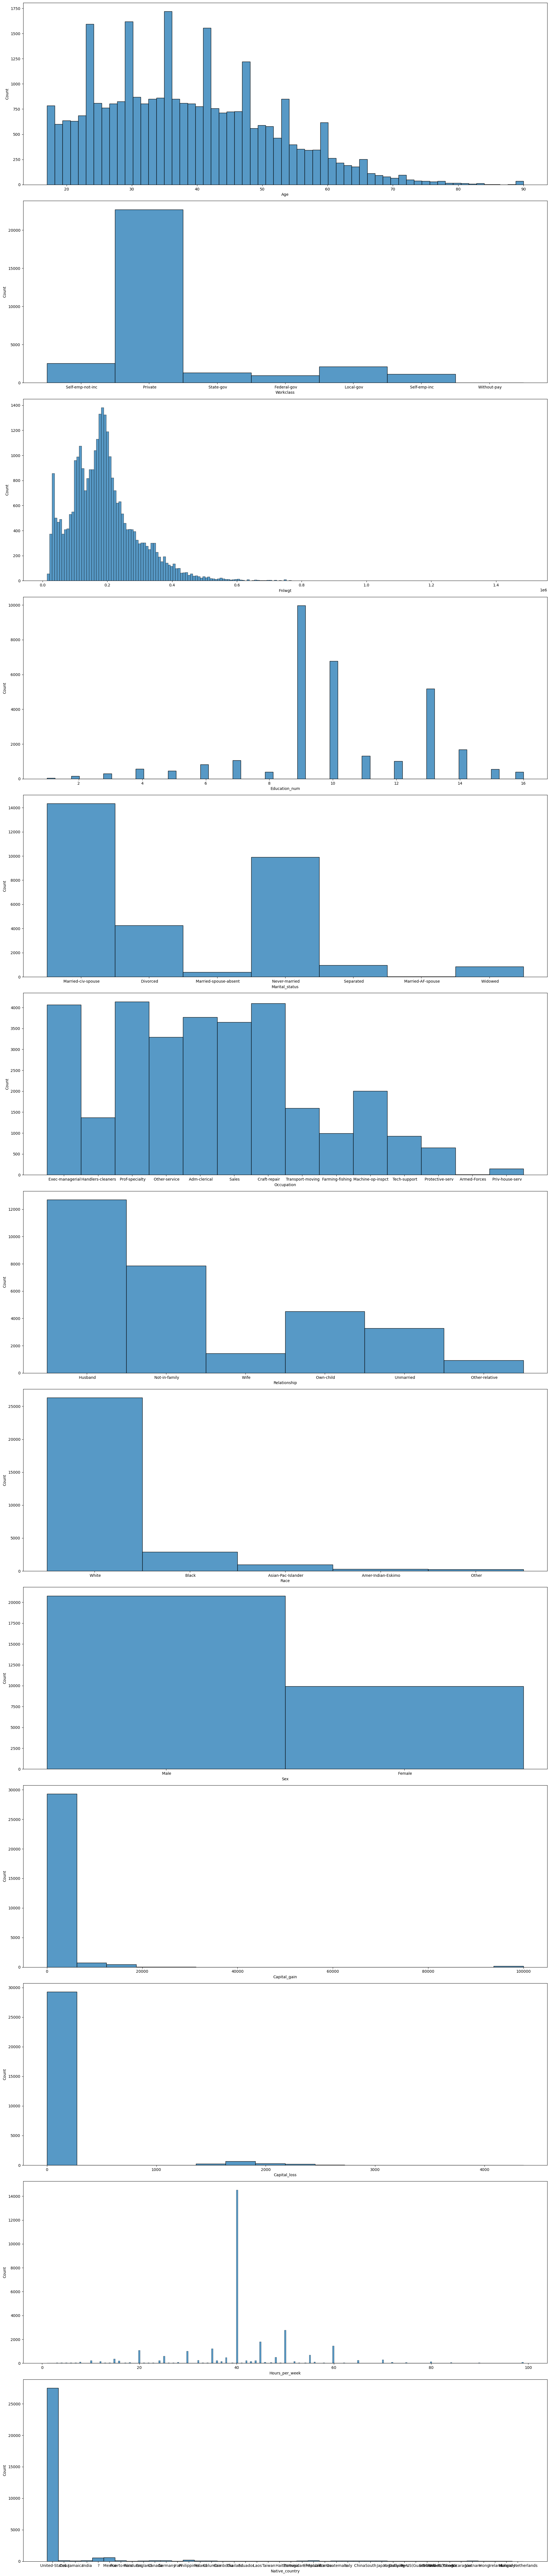

In [97]:
eda.all_col_histplots()

1. Age starts from 16 and is similar to normal distribution
2. Private sector have more employees than any other employees. That might cause our model tilt towards private more. We can even that out by oversampling other sectors
3. Fnlwgt is uneven but can be converted to normal distribution
4. Most of them are educated
5. other columns like married/ occupation, etc., are categorical
6. hours per week is discrete distribution
7. Most of them are US citizens which means we are more tilted towards their income

## Multivatiate Analysis

In [296]:
en = Encoder(dfx)

In [298]:
dfx['Income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [299]:
X,y = dfx.drop(columns=['Income']),dfx['Income']

In [301]:
dfx = en.label()
dfx = en.standard_scaler(dfx)

In [302]:
X = dfx.drop(columns=['Income'])

In [305]:
X

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
0,0.880945,1.889554,-1.010259,1.119950,-0.389862,-0.737056,-0.885015,0.390789,0.691160,-0.147509,-0.219183,-2.331953,0.292686
1,-0.033813,-0.209518,0.244621,-0.441076,-1.727071,-0.240267,-0.260560,0.390789,0.691160,-0.147509,-0.219183,-0.079208,0.292686
2,1.109634,-0.209518,0.425501,-1.221590,-0.389862,-0.240267,-0.885015,-1.978709,0.691160,-0.147509,-0.219183,-0.079208,0.292686
3,-0.796111,-0.209518,1.408732,1.119950,-0.389862,0.753310,2.237258,-1.978709,-1.446843,-0.147509,-0.219183,-0.079208,-4.045029
4,-0.110043,-0.209518,0.898313,1.510207,-0.389862,-0.737056,2.237258,0.390789,-1.446843,-0.147509,-0.219183,-0.079208,0.292686
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30712,-0.872341,-0.209518,0.639628,0.729694,-0.389862,1.498494,2.237258,0.390789,-1.446843,-0.147509,-0.219183,-0.246078,0.292686
30713,0.118647,-0.209518,-0.336397,-0.441076,-0.389862,0.008127,-0.885015,0.390789,0.691160,-0.147509,-0.219183,-0.079208,0.292686
30714,1.490783,-0.209518,-0.359762,-0.441076,2.284558,-1.482240,1.612803,0.390789,-1.446843,-0.147509,-0.219183,-0.079208,0.292686
30715,-1.253490,-0.209518,0.110385,-0.441076,0.947348,-1.482240,0.988349,0.390789,0.691160,-0.147509,-0.219183,-1.747908,0.292686


In [306]:
y

0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
32555     <=50K
32556      >50K
32557     <=50K
32558     <=50K
32559      >50K
Name: Income, Length: 30717, dtype: object

In [307]:
X = en.standard_scaler(X)
X

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
0,0.880945,1.889554,-1.010259,1.119950,-0.389862,-0.737056,-0.885015,0.390789,0.691160,-0.147509,-0.219183,-2.331953,0.292686
1,-0.033813,-0.209518,0.244621,-0.441076,-1.727071,-0.240267,-0.260560,0.390789,0.691160,-0.147509,-0.219183,-0.079208,0.292686
2,1.109634,-0.209518,0.425501,-1.221590,-0.389862,-0.240267,-0.885015,-1.978709,0.691160,-0.147509,-0.219183,-0.079208,0.292686
3,-0.796111,-0.209518,1.408732,1.119950,-0.389862,0.753310,2.237258,-1.978709,-1.446843,-0.147509,-0.219183,-0.079208,-4.045029
4,-0.110043,-0.209518,0.898313,1.510207,-0.389862,-0.737056,2.237258,0.390789,-1.446843,-0.147509,-0.219183,-0.079208,0.292686
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30712,-0.872341,-0.209518,0.639628,0.729694,-0.389862,1.498494,2.237258,0.390789,-1.446843,-0.147509,-0.219183,-0.246078,0.292686
30713,0.118647,-0.209518,-0.336397,-0.441076,-0.389862,0.008127,-0.885015,0.390789,0.691160,-0.147509,-0.219183,-0.079208,0.292686
30714,1.490783,-0.209518,-0.359762,-0.441076,2.284558,-1.482240,1.612803,0.390789,-1.446843,-0.147509,-0.219183,-0.079208,0.292686
30715,-1.253490,-0.209518,0.110385,-0.441076,0.947348,-1.482240,0.988349,0.390789,0.691160,-0.147509,-0.219183,-1.747908,0.292686


In [308]:
dfx = en.standard_scaler(dfx)

In [309]:
dfx.corr()

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
Age,1.000000,0.081053,-0.076540,0.043566,-0.276798,-0.006036,-0.246038,0.025218,0.082116,0.080392,0.060409,0.101880,-0.003487,0.242433
Workclass,0.081053,1.000000,-0.032144,0.038222,-0.035239,0.015197,-0.066924,0.043340,0.075046,0.034430,0.008369,0.050196,0.003896,0.019186
Fnlwgt,-0.076540,-0.032144,1.000000,-0.043472,0.031736,0.000625,0.007948,-0.023418,0.026593,-0.000184,-0.010018,-0.022814,-0.053408,-0.009466
Education_num,0.043566,0.038222,-0.043472,1.000000,-0.063899,0.089164,-0.092237,0.029809,0.007418,0.124245,0.079330,0.151247,0.053220,0.334670
Marital_status,-0.276798,-0.035239,0.031736,-0.063899,1.000000,0.022422,0.179152,-0.067850,-0.120384,-0.042999,-0.035602,-0.186770,-0.029274,-0.194568
Occupation,-0.006036,0.015197,0.000625,0.089164,0.022422,1.000000,-0.053015,-0.001231,0.062104,0.021426,0.013031,0.018293,-0.011072,0.050118
Relationship,-0.246038,-0.066924,0.007948,-0.092237,0.179152,-0.053015,1.000000,-0.115375,-0.585791,-0.056752,-0.062583,-0.257289,-0.005065,-0.251261
Race,0.025218,0.043340,-0.023418,0.029809,-0.067850,-0.001231,-0.115375,1.000000,0.086139,0.011524,0.020967,0.044811,0.141008,0.070935
Sex,0.082116,0.075046,0.026593,0.007418,-0.120384,0.062104,-0.585791,0.086139,1.000000,0.047755,0.047015,0.230325,-0.010068,0.216641
Capital_gain,0.080392,0.034430,-0.000184,0.124245,-0.042999,0.021426,-0.056752,0.011524,0.047755,1.000000,-0.032331,0.079548,-0.002319,0.221875


In [310]:
eda.target

'Income'

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


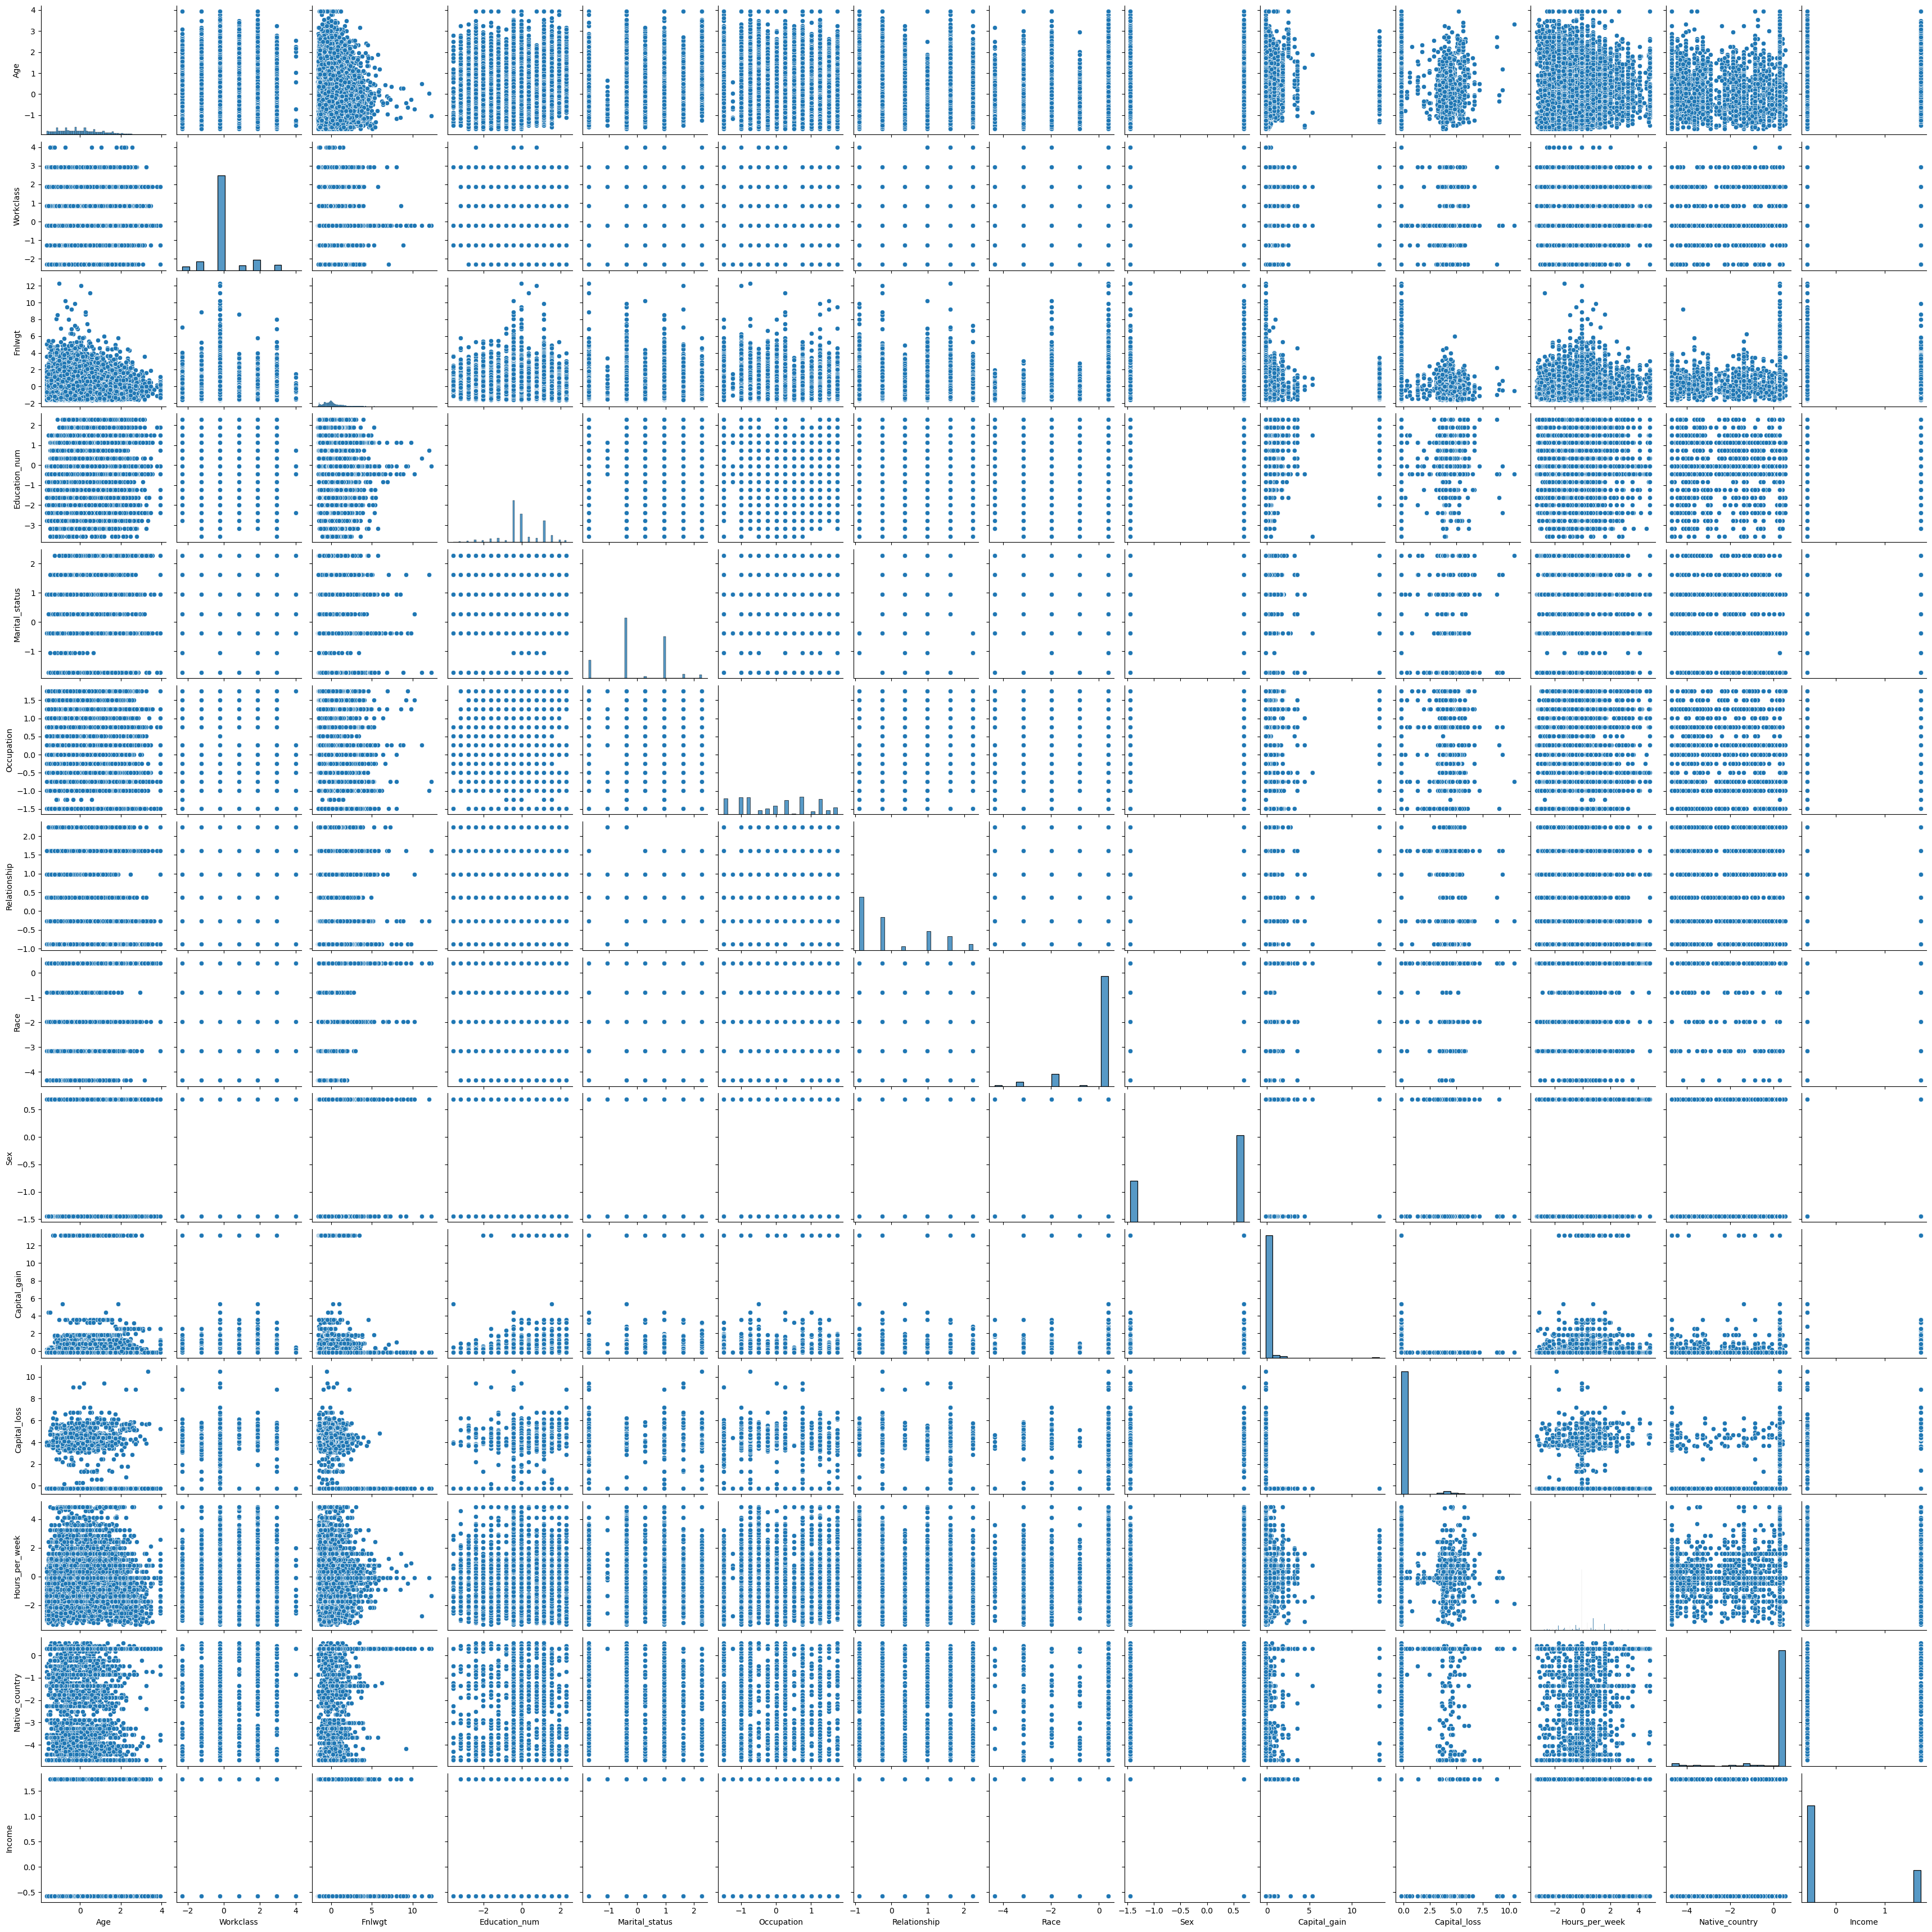

In [311]:
sns.pairplot(dfx)

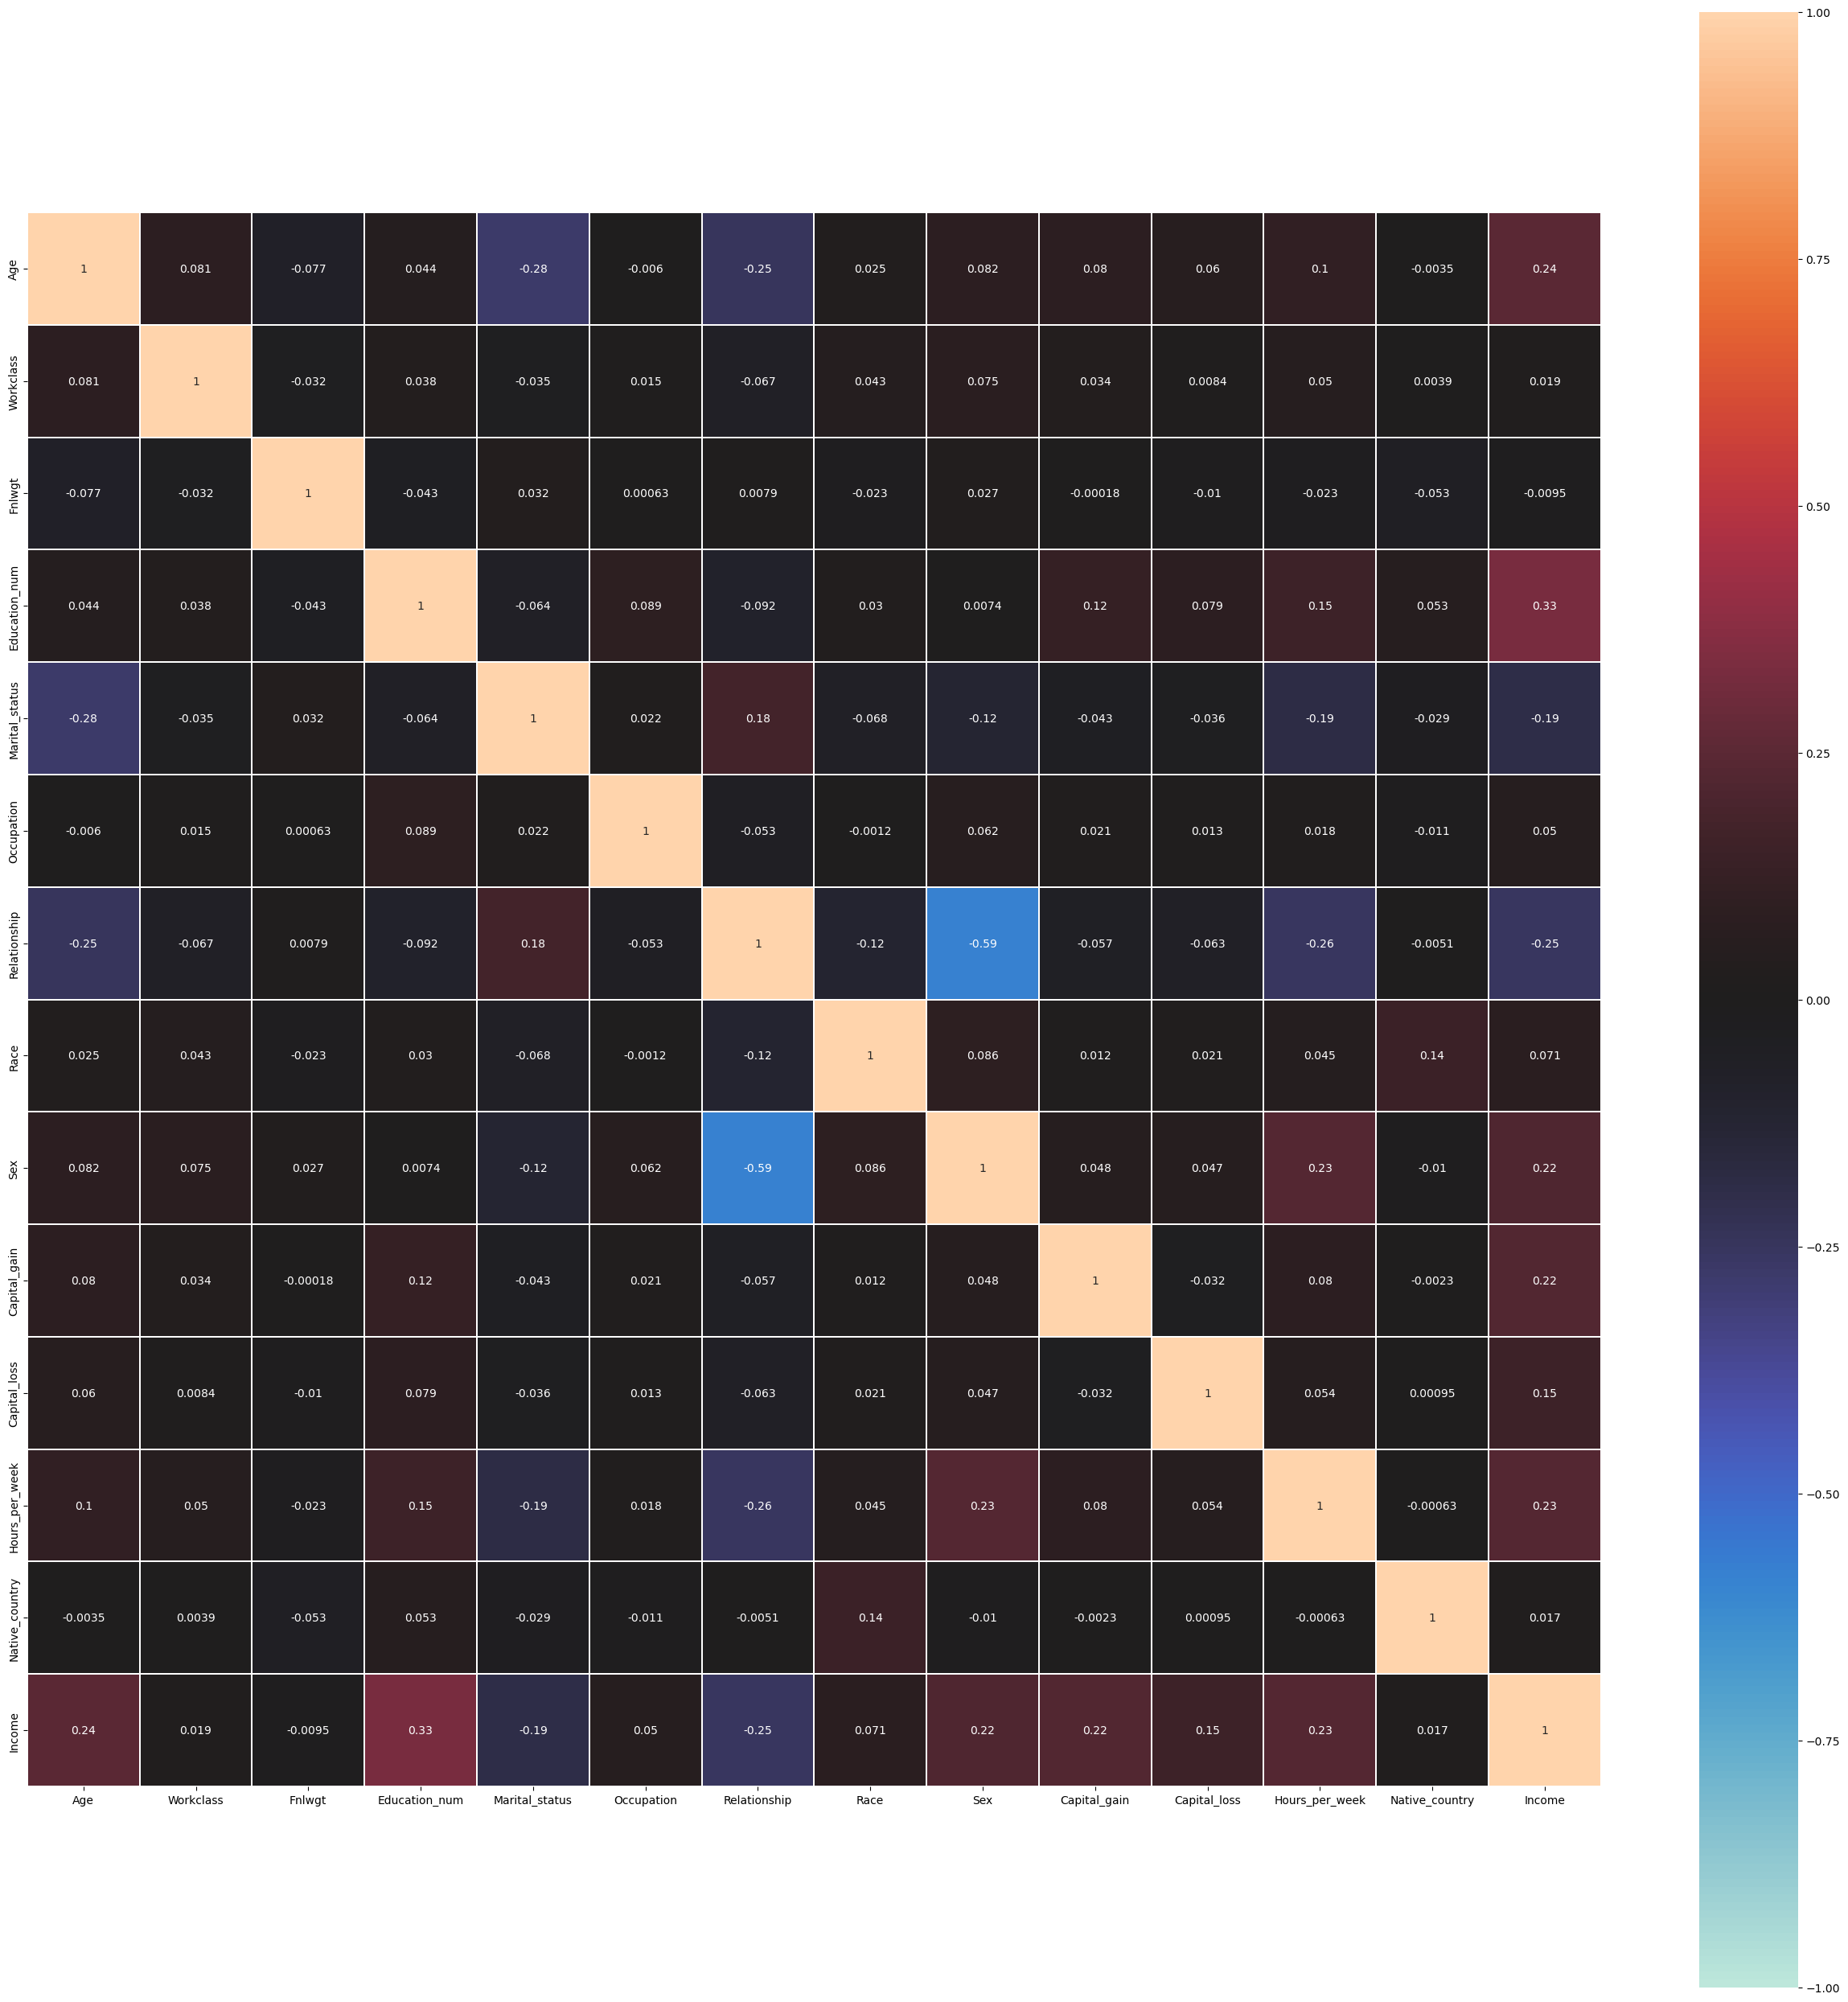

In [162]:
eda = EDA()
eda.corr_plot(dfx)

We can see that the correlations are very less. That's a good sign. Now we can check outlier influence and skewness

### Checking outlier influence

In [312]:
eda = EDA()
eda.target = 'Income'

vif = eda.get_vif(dfx)

      values        features
0   1.158371             Age
1   1.015552       Workclass
2   1.012768          Fnlwgt
3   1.065209   Education_num
4   1.127469  Marital_status
5   1.014001      Occupation
6   1.676886    Relationship
7   1.038817            Race
8   1.568953             Sex
9   1.028865    Capital_gain
10  1.015454    Capital_loss
11  1.130390  Hours_per_week
12  1.026775  Native_country


we can see that there is not much effect of outliers and we have good view.

In [313]:
X.skew()

Age                0.531692
Workclass          1.153292
Fnlwgt             1.457202
Education_num     -0.310305
Marital_status    -0.010160
Occupation         0.107012
Relationship       0.822358
Race              -2.456046
Sex               -0.755719
Capital_gain      11.785715
Capital_loss       4.514245
Hours_per_week     0.331806
Native_country    -3.643144
dtype: float64

We have skewness in some of the columns like workclass, FFnlwgt, race, Capitalgain, capital loss, native country etc., we need to reduce that. We can use sqrt transform and penalize the values.

In [314]:
enx = Encoder(X)

In [315]:
X = enx.do_yeo(X)

In [316]:
X.skew()

Age               0.061761
Workclass        -0.438322
Fnlwgt            0.028473
Education_num    -0.310305
Marital_status   -0.010160
Occupation        0.107012
Relationship      0.282068
Race             -2.030562
Sex              -0.755719
Capital_gain      3.007265
Capital_loss      4.251633
Hours_per_week    0.331806
Native_country   -2.035268
dtype: float64

In [317]:
X.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
dtype: int64

We can see a significant reduction in skewness. Now our data is ready for training.

# Training

In [318]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


classifiers = {
    'RandomForest' : (RandomForestClassifier(), {'n_estimators':[100,200,300,400,500], 'max_depth':[None, 10,20,30, 40, 50]}),
    'GradientBoost': (GradientBoostingClassifier(),{'n_estimators':[50,100,150,200,250],'learning_rate':[0.05,0.1]}),
    'SVC' : (SVC(),{'C':[1,5,10],'kernel':['linear','rbf']}),
    'KNN': (KNeighborsClassifier(),{'n_neighbors':[5,10,15,20,25]}),
    'DecisionTree': (DecisionTreeClassifier(),{'max_depth':[100,150,200,250],'max_leaf_nodes':[50,100]})
}

In [319]:
y.unique()

array([' <=50K', ' >50K'], dtype=object)

In [320]:
bscore = 0
bmodel = ''

for cl, (clas, param_grid) in classifiers.items():
    
    grid_search = GridSearchCV(clas, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X,y)
    print(grid_search.best_score_)
    if grid_search.best_score_ > bscore:
        bscore = grid_search.best_score_
        bmodel = cl
        params = grid_search.best_params_
print(f"Best model: {bmodel} with accuracy {bscore:.4f}")

0.8571151128147214
0.8621938101124587
0.8356613398465056
0.8283038801362661
0.8510923733059987
Best model: GradientBoost with accuracy 0.8622


In [321]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=150, max_leaf_nodes=100)

In [322]:
grid_search.best_score_

0.8510923733059987

In [323]:
import joblib

joblib.dump(grid_search.best_estimator_, 'model.joblib')
model = joblib.load('model.joblib')

In [324]:
data = X.iloc[[0]]
print(data)
model.predict(data)

        Age  Workclass    Fnlwgt  Education_num  Marital_status  Occupation  \
0  0.780797   1.430094 -1.253084        1.11995       -0.389862   -0.737056   

   Relationship      Race       Sex  Capital_gain  Capital_loss  \
0     -1.284144  0.971709  1.177154     -0.458321     -0.815118   

   Hours_per_week  Native_country  
0       -2.331953        0.748944  


array([' <=50K'], dtype=object)

In [325]:
y.iloc[0]

' <=50K'

We got really good accuracy. Hence we can finalize our model as DecisionTree with max_depth=150, max_leaf_nodes=100.